# Training the hand classification model

In [2]:
import os
import uuid
from datetime import datetime
import pickle
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold

In [ ]:
# Model Base Types
Sequential = tf.keras.models.Sequential

# Layers
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout

# Optimizers
Adam = tf.keras.optimizers.Adam

# Helper Functions

In [ ]:
# Function reorders the data so that simular data represenations are near each other.
def reorder_data_cols(data):
    df = data.copy()
    dfc = df[['C1', 'C2', 'C3', 'C4', 'C5']]
    dfc.values.sort()
    df[['C1', 'C2', 'C3', 'C4', 'C5']] = dfc
    df = df[['C1', 'C2', 'C3', 'C4', 'C5', 'S1', 'S2', 'S3', 'S4', 'S5', 'Label']]
    return df

In [ ]:
# Function generates the confusion matrics data as a graphic
def print_cmat(cm, labels=None):
  """ Helper function to visualize confusion matrices. """
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, fmt="g", cmap="YlGnBu", linewidths=0.5, ax=ax)
  
  ax.set_title("Confusion Matrix")
  ax.set_xlabel("Predicted Labels")
  ax.set_ylabel("True Labels")
  
  if labels:
      ax.xaxis.set_ticklabels(labels)
      ax.yaxis.set_ticklabels(labels)
  plt.show()

In [ ]:
train_data = pd.read_csv('data/poker-hand-training-true.data', header=None)
train_data.columns = ['S1', 'C1','S2', 'C2','S3', 'C3','S4', 'C4','S5', 'C5','Label']
train_data = reorder_data_cols(train_data)


test_data = pd.read_csv('data/poker-hand-testing.data', index_col=None)
test_data.columns = ['S1', 'C1','S2', 'C2','S3', 'C3','S4', 'C4','S5', 'C5','Label']
test_data = reorder_data_cols(test_data)

In [ ]:
train_data.describe()

,C1,C2,C3,C4,C5,S1,S2,S3,S4,S5,Label
count,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000
mean,2.600080,4.766693,6.995082,9.192923,11.374010,2.508756,2.497721,2.510236,2.495922,2.497321,0.621152
std,1.737962,2.256863,2.390171,2.262654,1.756516,1.116483,1.121767,1.123148,1.116009,1.118732,0.788361
min,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,3.000000,5.000000,8.000000,10.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,2.000000,5.000000,7.000000,9.000000,12.000000,3.000000,2.000000,3.000000,2.000000,3.000000,1.000000
75%,3.000000,6.000000,9.000000,11.000000,13.000000,4.000000,4.000000,4.000000,3.000000,3.000000,1.000000
max,11.000000,12.000000,13.000000,13.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,9.000000


<AxesSubplot:xlabel='Label', ylabel='Count'>

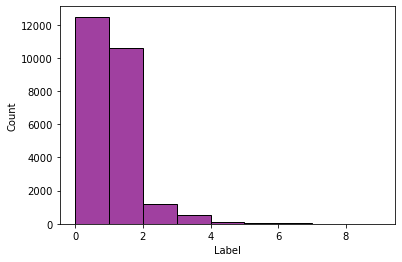

In [ ]:
sns.histplot(data=train_data['Label'], binwidth=1, color="purple")

/Users/joe/opt/anaconda3/envs/poker/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Label', ylabel='Density'>

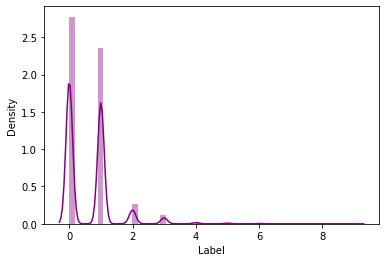

In [ ]:
sns.distplot(train_data['Label'], color="purple")

# Prepare Test/Train Data

In [ ]:
# Group data based on feature and label status.

x_train = train_data[train_data.columns[:10]]
y_train = train_data[train_data.columns[10]]
x_test = test_data[test_data.columns[:10]]
y_test = test_data[test_data.columns[10]]

x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

# Test Classical Machine Learning Model

In [ ]:
criterion_options = ['entropy','gini']
splitter_options = ['best','random']
max_depth_options = [None,1,5,10,20,30,40,50,100,200]
min_samples_split_options = [2,5,7,10,20,40,50]
max_leaf_nodes_options = [None,2,5,7,10,20,30,50,100,200]

In [ ]:
total_models_to_generate = len(criterion_options) * len(splitter_options) * len(max_depth_options) * len(min_samples_split_options) * len(max_leaf_nodes_options)
models_generated = 0

# Create instance of the classical model and test
tree_model_results_df = pd.DataFrame(columns=['criterion','splitter','max_depth','min_samples','max_leaf_nodes','accuracy'])
now_folder_name = datetime.now().strftime("%Y%m%d-%H%M%S")


# Run test for a verity of diffrent configurations
for criterion in criterion_options:
    for splitter in splitter_options:
        for max_depth in max_depth_options:
            for min_samples_split in min_samples_split_options:
                for max_leaf_nodes in max_leaf_nodes_options:
                    print(f'{models_generated} / {total_models_to_generate}')
                    tree_model = DecisionTreeClassifier(random_state=1, criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split, max_leaf_nodes=max_leaf_nodes)
                    tree_model.fit(x_train, y_train)
                    y_pred = tree_model.predict(x_test)
                    accuracy = accuracy_score(y_test, y_pred, normalize=True,)
                    filename = 'tree_model-' + uuid.uuid4().hex + '.pickle'
                    row = {
                        'criterion':criterion,
                        'splitter':splitter,
                        'max_depth':max_depth,
                        'min_samples_split':min_samples_split,
                        'max_leaf_nodes':max_leaf_nodes,
                        'accuracy':accuracy,
                        'filename':filename
                    }
                    tree_model_results_df = tree_model_results_df.append(row, ignore_index=True)
                    models_generated += 1
                    save_path = f'pickled_models/{now_folder_name}/{filename}'
                    if os.path.exists(f'pickled_models/{now_folder_name}') == False:
                        os.makedirs(f'pickled_models/{now_folder_name}')

                    pickle.dump(tree_model, open(save_path, 'wb'))
tree_model_results_df.to_csv(f'pickled_models/{now_folder_name}/model_meta_data.csv')

0 / 2800
1 / 2800
2 / 2800
3 / 2800
4 / 2800
5 / 2800
6 / 2800
7 / 2800
8 / 2800
9 / 2800
10 / 2800
11 / 2800
12 / 2800
13 / 2800
14 / 2800
15 / 2800
16 / 2800
17 / 2800
18 / 2800
19 / 2800
20 / 2800
21 / 2800
22 / 2800
23 / 2800
24 / 2800
25 / 2800
26 / 2800
27 / 2800
28 / 2800
29 / 2800
30 / 2800
31 / 2800
32 / 2800
33 / 2800
34 / 2800
35 / 2800
36 / 2800
37 / 2800
38 / 2800
39 / 2800
40 / 2800
41 / 2800
42 / 2800
43 / 2800
44 / 2800
45 / 2800
46 / 2800
47 / 2800
48 / 2800
49 / 2800
50 / 2800
51 / 2800
52 / 2800
53 / 2800
54 / 2800
55 / 2800
56 / 2800
57 / 2800
58 / 2800
59 / 2800
60 / 2800
61 / 2800
62 / 2800
63 / 2800
64 / 2800
65 / 2800
66 / 2800
67 / 2800
68 / 2800
69 / 2800
70 / 2800
71 / 2800
72 / 2800
73 / 2800
74 / 2800
75 / 2800
76 / 2800
77 / 2800
78 / 2800
79 / 2800
80 / 2800
81 / 2800
82 / 2800
83 / 2800
84 / 2800
85 / 2800
86 / 2800
87 / 2800
88 / 2800
89 / 2800
90 / 2800
91 / 2800
92 / 2800
93 / 2800
94 / 2800
95 / 2800
96 / 2800
97 / 2800
98 / 2800
99 / 2800
100 / 2800

755 / 2800
756 / 2800
757 / 2800
758 / 2800
759 / 2800
760 / 2800
761 / 2800
762 / 2800
763 / 2800
764 / 2800
765 / 2800
766 / 2800
767 / 2800
768 / 2800
769 / 2800
770 / 2800
771 / 2800
772 / 2800
773 / 2800
774 / 2800
775 / 2800
776 / 2800
777 / 2800
778 / 2800
779 / 2800
780 / 2800
781 / 2800
782 / 2800
783 / 2800
784 / 2800
785 / 2800
786 / 2800
787 / 2800
788 / 2800
789 / 2800
790 / 2800
791 / 2800
792 / 2800
793 / 2800
794 / 2800
795 / 2800
796 / 2800
797 / 2800
798 / 2800
799 / 2800
800 / 2800
801 / 2800
802 / 2800
803 / 2800
804 / 2800
805 / 2800
806 / 2800
807 / 2800
808 / 2800
809 / 2800
810 / 2800
811 / 2800
812 / 2800
813 / 2800
814 / 2800
815 / 2800
816 / 2800
817 / 2800
818 / 2800
819 / 2800
820 / 2800
821 / 2800
822 / 2800
823 / 2800
824 / 2800
825 / 2800
826 / 2800
827 / 2800
828 / 2800
829 / 2800
830 / 2800
831 / 2800
832 / 2800
833 / 2800
834 / 2800
835 / 2800
836 / 2800
837 / 2800
838 / 2800
839 / 2800
840 / 2800
841 / 2800
842 / 2800
843 / 2800
844 / 2800
845 / 2800

1459 / 2800
1460 / 2800
1461 / 2800
1462 / 2800
1463 / 2800
1464 / 2800
1465 / 2800
1466 / 2800
1467 / 2800
1468 / 2800
1469 / 2800
1470 / 2800
1471 / 2800
1472 / 2800
1473 / 2800
1474 / 2800
1475 / 2800
1476 / 2800
1477 / 2800
1478 / 2800
1479 / 2800
1480 / 2800
1481 / 2800
1482 / 2800
1483 / 2800
1484 / 2800
1485 / 2800
1486 / 2800
1487 / 2800
1488 / 2800
1489 / 2800
1490 / 2800
1491 / 2800
1492 / 2800
1493 / 2800
1494 / 2800
1495 / 2800
1496 / 2800
1497 / 2800
1498 / 2800
1499 / 2800
1500 / 2800
1501 / 2800
1502 / 2800
1503 / 2800
1504 / 2800
1505 / 2800
1506 / 2800
1507 / 2800
1508 / 2800
1509 / 2800
1510 / 2800
1511 / 2800
1512 / 2800
1513 / 2800
1514 / 2800
1515 / 2800
1516 / 2800
1517 / 2800
1518 / 2800
1519 / 2800
1520 / 2800
1521 / 2800
1522 / 2800
1523 / 2800
1524 / 2800
1525 / 2800
1526 / 2800
1527 / 2800
1528 / 2800
1529 / 2800
1530 / 2800
1531 / 2800
1532 / 2800
1533 / 2800
1534 / 2800
1535 / 2800
1536 / 2800
1537 / 2800
1538 / 2800
1539 / 2800
1540 / 2800
1541 / 2800
1542

2143 / 2800
2144 / 2800
2145 / 2800
2146 / 2800
2147 / 2800
2148 / 2800
2149 / 2800
2150 / 2800
2151 / 2800
2152 / 2800
2153 / 2800
2154 / 2800
2155 / 2800
2156 / 2800
2157 / 2800
2158 / 2800
2159 / 2800
2160 / 2800
2161 / 2800
2162 / 2800
2163 / 2800
2164 / 2800
2165 / 2800
2166 / 2800
2167 / 2800
2168 / 2800
2169 / 2800
2170 / 2800
2171 / 2800
2172 / 2800
2173 / 2800
2174 / 2800
2175 / 2800
2176 / 2800
2177 / 2800
2178 / 2800
2179 / 2800
2180 / 2800
2181 / 2800
2182 / 2800
2183 / 2800
2184 / 2800
2185 / 2800
2186 / 2800
2187 / 2800
2188 / 2800
2189 / 2800
2190 / 2800
2191 / 2800
2192 / 2800
2193 / 2800
2194 / 2800
2195 / 2800
2196 / 2800
2197 / 2800
2198 / 2800
2199 / 2800
2200 / 2800
2201 / 2800
2202 / 2800
2203 / 2800
2204 / 2800
2205 / 2800
2206 / 2800
2207 / 2800
2208 / 2800
2209 / 2800
2210 / 2800
2211 / 2800
2212 / 2800
2213 / 2800
2214 / 2800
2215 / 2800
2216 / 2800
2217 / 2800
2218 / 2800
2219 / 2800
2220 / 2800
2221 / 2800
2222 / 2800
2223 / 2800
2224 / 2800
2225 / 2800
2226

In [ ]:
tree_model_results_df.sort_values('accuracy', ascending=False)

,criterion,splitter,max_depth,min_samples,max_leaf_nodes,accuracy,filename,min_samples_split
1140,entropy,random,40,NaN,None,0.968648,tree_model-7aec4be737b34f99a7ec1df59abdcb45.pi...,7.0
1210,entropy,random,50,NaN,None,0.968648,tree_model-e4af06ef410543378bc1920d81466d5e.pi...,7.0
1350,entropy,random,200,NaN,None,0.968648,tree_model-c400647068be463580681e5e174027af.pi...,7.0
720,entropy,random,None,NaN,None,0.968648,tree_model-c2f82f57547e4feca20b5b6065663caf.pi...,7.0
1070,entropy,random,30,NaN,None,0.968648,tree_model-39a5d2d6a00f4a5c8deb686b08aa10f0.pi...,7.0
...,...,...,...,...,...,...,...,...
1071,entropy,random,30,NaN,2,0.529503,tree_model-526fba9bf2124e6ab10fe56b48472cfe.pi...,7.0
2190,gini,random,1,NaN,None,0.529503,tree_model-ac789682c0694e51a51e855a7a1a8dea.pi...,7.0
2191,gini,random,1,NaN,2,0.529503,tree_model-7762c3b495c842219426e3728c4a255e.pi...,7.0
2631,gini,random,50,NaN,2,0.529503,tree_model-04925ae175be4a5eb59d84348049c87e.pi...,20.0


criterion: entropy | splitter: random | max_depth: 40 | min_samples_split: 50 | max_leaf_nodes: None | accuracy: 0.9686479686479686


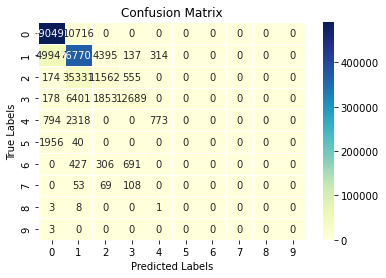

criterion: entropy | splitter: random | max_depth: 50 | min_samples_split: 50 | max_leaf_nodes: None | accuracy: 0.9686479686479686


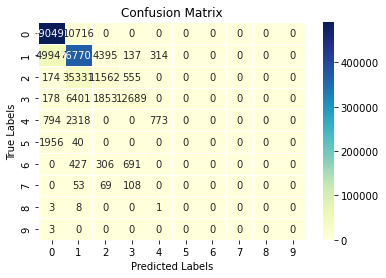

criterion: entropy | splitter: random | max_depth: 200 | min_samples_split: 50 | max_leaf_nodes: None | accuracy: 0.9686479686479686


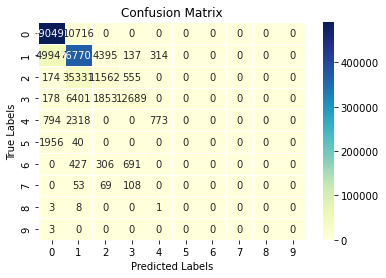

criterion: entropy | splitter: random | max_depth: None | min_samples_split: 50 | max_leaf_nodes: None | accuracy: 0.9686479686479686


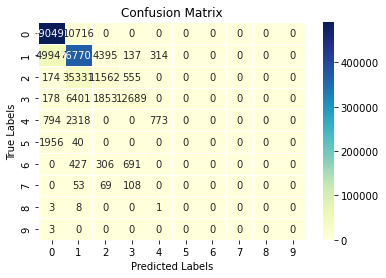

criterion: entropy | splitter: random | max_depth: 30 | min_samples_split: 50 | max_leaf_nodes: None | accuracy: 0.9686479686479686


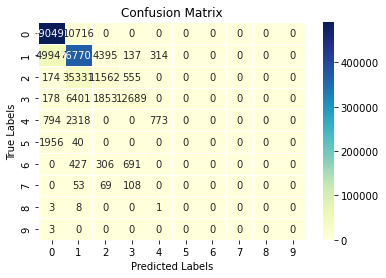

In [ ]:
for index in range(5):
    top_model_stats = tree_model_results_df.sort_values('accuracy', ascending=False).iloc[index]
    criterion = top_model_stats['criterion']
    splitter = top_model_stats['splitter']
    max_depth = top_model_stats['max_depth']
    min_samples = top_model_stats['min_samples']
    max_leaf_nodes = top_model_stats['max_leaf_nodes']
    accuracy = top_model_stats['accuracy']
    tree_model = DecisionTreeClassifier(random_state=1, criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split, max_leaf_nodes=max_leaf_nodes)
    tree_model.fit(x_train, y_train)
    y_pred = tree_model.predict(x_test)

    cmat = confusion_matrix(y_true=y_test, 
                            y_pred=y_pred)
    print(f'criterion: {criterion} | splitter: {splitter} | max_depth: {max_depth} | min_samples_split: {min_samples_split} | max_leaf_nodes: {max_leaf_nodes} | accuracy: {accuracy}')
    print_cmat(cmat)

# Test Deep Learning Model

In [ ]:
# Layer Creation

input_layer = Dense(10, activation="linear")

dense_layer_1 = Dense(30, activation="relu")

dropout_layer_1 = Dropout(.05)

dense_layer_2 = Dense(20, activation="relu")

dropout_layer_2 = Dropout(.05)

dense_layer_3 = Dense(15, activation="relu")

output_layer = Dense(10, activation="linear")

In [ ]:
# Sequential Model Architecture Design
model = Sequential()

# Add All Initialized Layers in Effective Sequence
model.add(input_layer)
model.add(dense_layer_1)
model.add(dropout_layer_1)
model.add(dense_layer_2)
model.add(dropout_layer_2)
model.add(dense_layer_3)
model.add(output_layer)


In [ ]:
# Define Adam optimization
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
batch_size, epochs = 5000, 10

# Fit Learning Model Using Training Data and Configured Hyperparameters
history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                   verbose=True)

# Get Model Summary for Confirmation
model.summary()

2022-03-18 18:51:57.274955: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-18 18:51:57.275300: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


Train on 25010 samples
Epoch 1/10
25010/25010 [==============================] - 1s 49us/sample - loss: 2.9544 - accuracy: 0.0386
Epoch 2/10
25010/25010 [==============================] - 0s 4us/sample - loss: 2.0637 - accuracy: 0.0603
Epoch 3/10
25010/25010 [==============================] - 0s 5us/sample - loss: 2.0044 - accuracy: 0.1067
Epoch 4/10
25010/25010 [==============================] - 0s 4us/sample - loss: 1.9932 - accuracy: 0.1803
Epoch 5/10
25010/25010 [==============================] - 0s 4us/sample - loss: 1.9902 - accuracy: 0.2518
Epoch 6/10
25010/25010 [==============================] - 0s 4us/sample - loss: 1.9884 - accuracy: 0.2898
Epoch 7/10
25010/25010 [==============================] - 0s 4us/sample - loss: 1.9870 - accuracy: 0.3190
Epoch 8/10
25010/25010 [==============================] - 0s 4us/sample - loss: 1.9858 - accuracy: 0.3359
Epoch 9/10
25010/25010 [==============================] - 0s 4us/sample - loss: 1.9869 - accuracy: 0.3465
Epoch 10/10
25010/2501

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Accuracy: {accuracy}\nLoss: {loss:.4f}")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Accuracy: 0.3586563467979431
Loss: 1.9859


In [ ]:
# Get Our Predicted Labels
y_pred = np.argmax(model.predict(x_test), axis=1)

In [ ]:
# Create Simple Confusion Matrix as 2D Array
cmat = confusion_matrix(y_true=y_test, 
                        y_pred=y_pred)

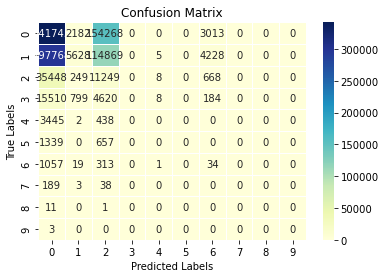

In [ ]:
cmat = confusion_matrix(y_true=y_test, 
                        y_pred=y_pred)
print_cmat(cmat)